In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import csv
from pathlib import Path
import sys
sys.path.append('..')
sys.path.append('../../GetData')
from macro import get_neighbour_sum_matrix, calcMag, calcEnergy
import pandas as pd
import seaborn as sns
import input_pipeline

2024-02-11 15:15:54.876677: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-11 15:15:55.591738: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-11 15:15:55.592165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-11 15:15:55.725962: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-11 15:15:56.017995: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-11 15:15:56.022947: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Model

In [2]:
latent_dim = 200

In [11]:
class VAE(tf.keras.Model):
  """Variational autoencoder."""

  def __init__(self, latent_dim, kernel_size = 3, lattice_size = 32):
    super(VAE, self).__init__()
    self.latent_dim = latent_dim
    #self.decode_size = int(lattice_size / 4)
    self.encoder = tf.keras.Sequential(
        [
          tf.keras.layers.Conv2D(32, (kernel_size, kernel_size), activation='relu', padding="same", input_shape=(32, 32, 1)),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Conv2D(64, (kernel_size, kernel_size), padding="same", activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.MaxPooling2D((2, 2)),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Conv2D(64, (kernel_size, kernel_size), padding="same", activation='relu'),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dropout(0.3),
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(latent_dim + latent_dim)
          ]
     )

    self.decoder = tf.keras.Sequential(
        [
          tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
          tf.keras.layers.Dense(units=8*8*32, activation=tf.nn.relu),
          tf.keras.layers.Reshape(target_shape=(8, 8, 32)),
          tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=kernel_size, strides=(1, 1),padding="same",activation='relu'),
          tf.keras.layers.UpSampling2D(size=(2, 2)),
          tf.keras.layers.Conv2DTranspose(filters=64,kernel_size=kernel_size, strides=(1, 1),padding="same",activation='relu'),
          tf.keras.layers.UpSampling2D(size=(2, 2)),
          tf.keras.layers.Conv2DTranspose(filters=32,kernel_size=kernel_size, strides=(1, 1),padding="same",activation='relu'),
          tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=kernel_size, strides=(1, 1), padding="same"),
        ]
    )

  def call(self, inputs):
    mean, logvar = self.encode(inputs)
    z = self.reparameterize(mean, logvar)
    reconstructed = self.decode(z)
    return reconstructed
  
  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)

def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [12]:
def sample(num_examples_to_generate, model):
    random_mean = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])
    log_var = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

    z = model.reparameterize(random_mean, log_var)
    predictions = model.sample(z)
    return predictions

def load_model_at_T(t):
    model = VAE(latent_dim)
    dummy_input = tf.zeros((1, 32, 32, 1))
    model(dummy_input)
    model.load_weights(f'models/vae{t}.h5')
    return model

## models dictionary

In [47]:
temps = [1.5, 2.0, 2.5, 3.0]
models = {t: load_model_at_T(t) for t in temps}

# Example simulations

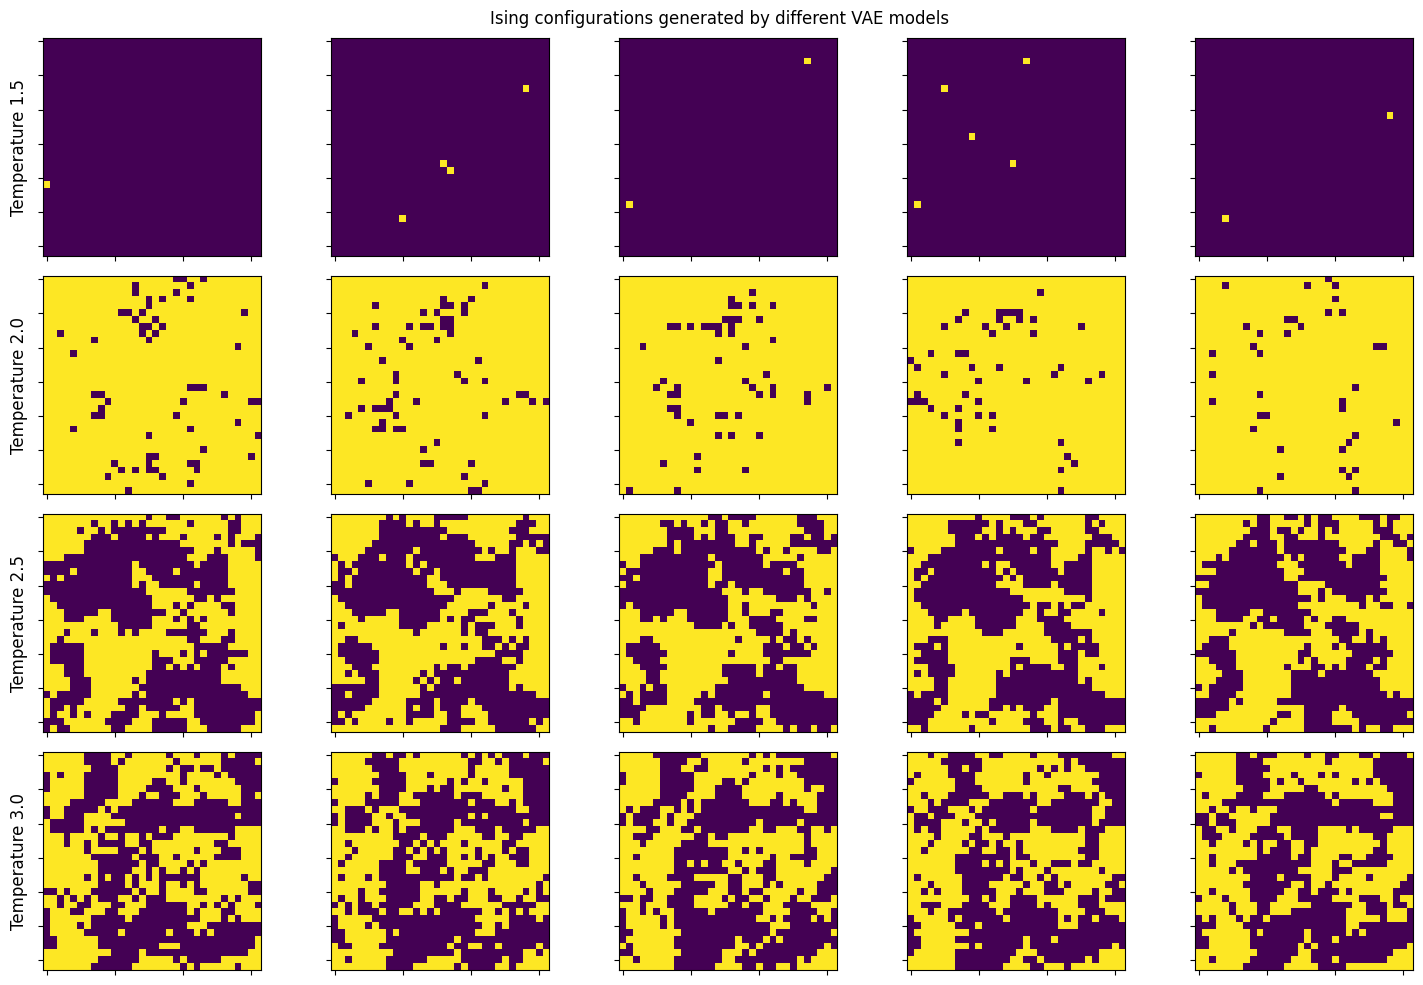

In [48]:
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(15, 10))
titles = ['Temperature 1.5','Temperature 2.0', 'Temperature 2.5', 'Temperature 3.0']

for i, ax_row in enumerate(axes):
    ax_row[0].set_ylabel(titles[i], rotation=90, size='large')
    predictions = sample(5, models[temps[i]])
    for j, ax in enumerate(ax_row):
        ax.yaxis.set_ticklabels([])
        ax.xaxis.set_ticklabels([])
        spins = np.random.binomial(1, predictions[i, :, :])
        ax.imshow(spins, vmin=0, vmax=1)

plt.suptitle("Ising configurations generated by different VAE models")
plt.tight_layout()

# Compare with monte carlo

In [49]:
num_examples_to_generate = 10000

random_vector_for_generation = tf.random.normal(
    shape=[num_examples_to_generate, latent_dim])

## Data

In [51]:
def get_df(data):
    df = pd.DataFrame({'image': list(data)})
    df['Magnetization'] = df['image'].apply(calcMag) / 32 ** 2
    df['Energy'] = df['image'].apply(calcEnergy)
    df.drop(columns='image', inplace=True)
    return df

def get_stats(df):
    return [df['Magnetization'].abs().mean(), df['Energy'].mean(), df['Magnetization'].var(), df['Energy'].var()]

data_list = []
for temp in temps:
    # Monte Carlo
    trainset_path = f"../../GetData/Python/Data/Data{temp}.tfrecord"
    batch_size = 10000
    train_set = input_pipeline.dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)
    data_mc = next(iter(train_set))
    data_mc = 2 * data_mc - 1
    df_monte_carlo = get_df(data_mc)
    mc_stats = get_stats(df_monte_carlo)
    mc_stats.extend((temp, "Monte Carlo"))

    # Sampled from VAE
    model = models[temp]
    sample_data = []
    for _ in range(100):
        sample_data.append(sample(100, model))
    spin_sample = tf.concat(sample_data, axis = 0)
    spin_sample = 2 * np.random.binomial(1, spin_sample) - 1
    df_sampled = get_df(spin_sample)
    sample_stats = get_stats(df_sampled)
    sample_stats.extend((temp, "Sampled VAE"))

    data_list.append(mc_stats)
    data_list.append(sample_stats)

In [54]:
df = pd.DataFrame(data_list, columns=['Magnetization', 'Energy', 'Magnetization Variance', 'Energy Variance', 'Temperature', 'Method'])
df.set_index(keys='Temperature', inplace=True)

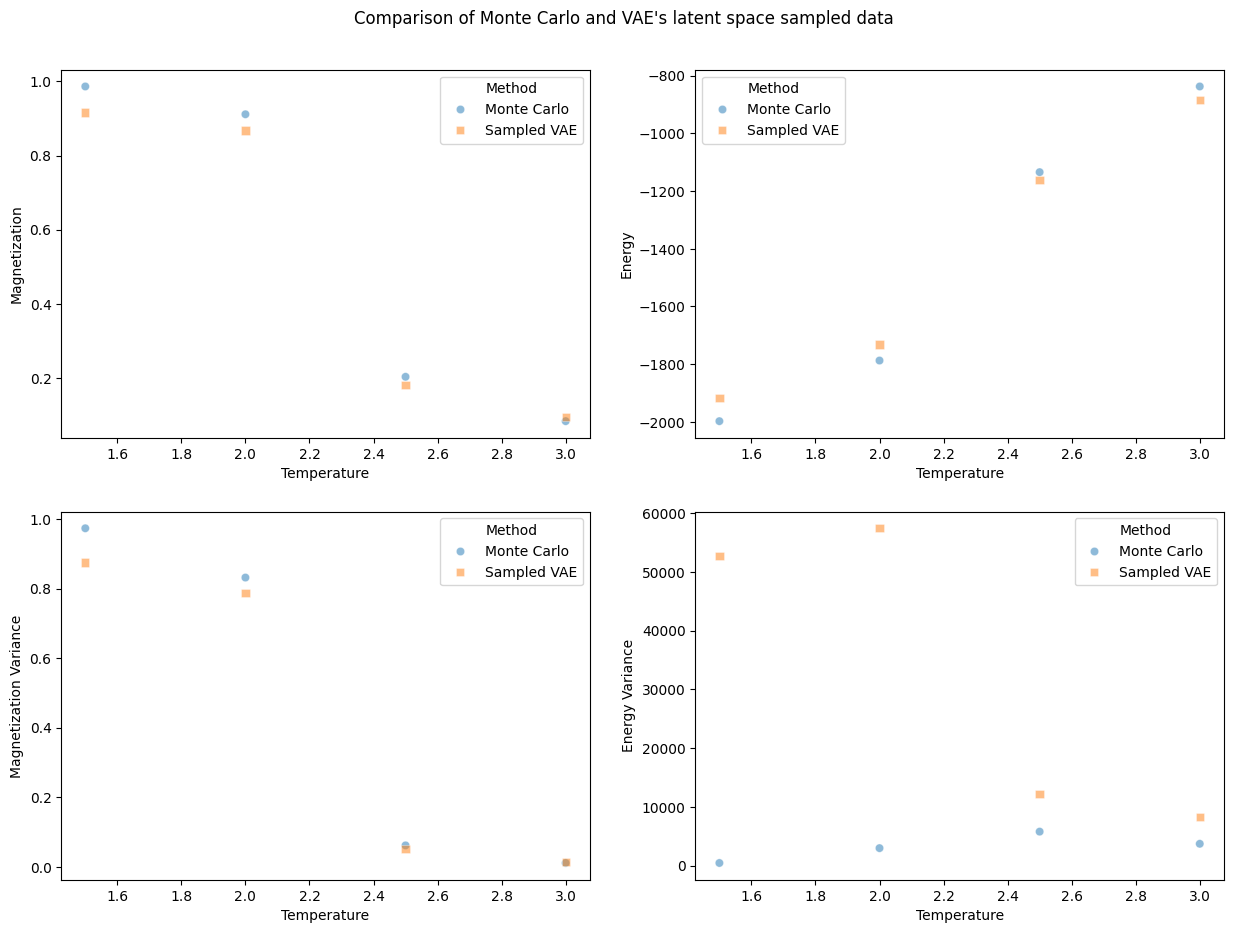

In [55]:
plt.figure(figsize=(15, 10))
plt.suptitle("Comparison of Monte Carlo and VAE's latent space sampled data")
plt.subplots_adjust(top=0.92)
for i, column in enumerate(['Magnetization', 'Energy', 'Magnetization Variance', 'Energy Variance']):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(data=df, x=df.index, y=column, hue = 'Method', style='Method', markers=['o', 's'], alpha=0.5)